# Exploración Juegos de Steam
### Grupo 10: Franco Becerra, Nicolás Becerra, Simón Sanfeliú y Antonio Vitalic
### Noviembre 2022

## Índice:
* [Introducción y motivación](#intro)
* [Exploración de datos](#exploracion)
*   * [Juegos con más horas de juego](#most_playtime)

# Introducción y motivación <a class="anchor" id="intro"></a>

El presente proyecto tiene como enfoque el estudio de la base de datos de juegos de Steam, un servicio de distribución digital de videojuegos establecido para juegos de computadora. La plataforma Steam es de los servicios más grandes en cuanto a la compra y venta de videojuegos en el mundo, teniendo un total de [132.000.000 de jugadores por mes (en 2021).](https://steamcommunity.com/groups/steamworks/announcements/detail/3133946090937137591) Dada la gran cantidad de dinero que fluye gracias a la industria de videojuegos [(T13)](https://steamcommunity.com/groups/steamworks/announcements/detail/3133946090937137591), es relevante estudiar cómo funciona una de las empresas más grandes en este rubro, viendo los juegos más demandados, los géneros más jugados, los precios de los juegos, los ratings de cada juego, entre otros. Luego, con toda esta información es posible hacerse una idea de cómo se está desarrollando esta industria y poder brindar un análisis a éste.

La base de datos obtenida, la cual cuenta con información recopilada por voluntarios sobre los juegos dentro de Steam hasta el año 2019, tiene distintos atributos relevantes para el estudio de esta industria, como es el nombre del juego, su distribuidor, su género, el tiempo promedio de juego por quienes lo han comprado, cuántas personas lo tienen, cuántas calificaciones negativas y positivas tiene, su precio, entre otras. Las mencionadas anteriormente serán las más importantes para este proyecto, pues fueron las usadas para poder generar un análisis más desarrollado de ésta. Por ejemplo, es posible ver cuáles juegos son los más jugados de forma simple y así buscar su información correspondiente, o ver qué empresas (distribuidoras) son las que ganan más dinero a partir de los juegos que publican, o ver también qué juegos gratuitos resultan ser los más populares dentro de la plataforma. Todas estas características permiten adentrarse más en los datos dados y así encontrar patrones de comportamiento útiles.

# Exploración de datos <a class="anchor" id="exploracion"></a>

La base de datos a utilizar fue obtenida en este [link](https://www.kaggle.com/datasets/nikdavis/steam-store-games) y muestra datos sobre los juegos dentro de Steam. Para cada uno de estos, muestra el nombre del juego, la fecha de lanzamiento, si se encuentra en inglés, el nombre del desarrollador y publicador, las plataformas a las que está disponible, la edad mínima requerida para poder jugar, las categorías del juego, su género, los tags de búsqueda, la cantidad de logros disponibles, la cantidad de calificaciones positivas y negativas, la mediana y el promedio del tiempo de juego, la cantidad de usuarios que poseen el juego y el valor monetario del juego.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="ticks", color_codes=True)
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, recall_score, precision_score, classification_report

steam = pd.DataFrame(pd.read_csv('steam.csv'))
steam.describe()


,appid,english,required_age,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,price
count,2.707500e+04,27075.000000,27075.000000,27075.000000,2.707500e+04,27075.000000,27075.000000,27075.00000,27075.000000
mean,5.962035e+05,0.981127,0.354903,45.248864,1.000559e+03,211.027147,149.804949,146.05603,6.078193
std,2.508942e+05,0.136081,2.406044,352.670281,1.898872e+04,4284.938531,1827.038141,2353.88008,7.874922
min,1.000000e+01,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.00000,0.000000
25%,4.012300e+05,1.000000,0.000000,0.000000,6.000000e+00,2.000000,0.000000,0.00000,1.690000
50%,5.990700e+05,1.000000,0.000000,7.000000,2.400000e+01,9.000000,0.000000,0.00000,3.990000
75%,7.987600e+05,1.000000,0.000000,23.000000,1.260000e+02,42.000000,0.000000,0.00000,7.190000
max,1.069460e+06,1.000000,18.000000,9821.000000,2.644404e+06,487076.000000,190625.000000,190625.00000,421.990000


In [362]:
steam.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27075 entries, 0 to 27074
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   appid             27075 non-null  int64  
 1   name              27075 non-null  object 
 2   release_date      27075 non-null  object 
 3   english           27075 non-null  int64  
 4   developer         27075 non-null  object 
 5   publisher         27075 non-null  object 
 6   platforms         27075 non-null  object 
 7   required_age      27075 non-null  int64  
 8   categories        27075 non-null  object 
 9   genres            27075 non-null  object 
 10  steamspy_tags     27075 non-null  object 
 11  achievements      27075 non-null  int64  
 12  positive_ratings  27075 non-null  int64  
 13  negative_ratings  27075 non-null  int64  
 14  average_playtime  27075 non-null  int64  
 15  median_playtime   27075 non-null  int64  
 16  owners            27075 non-null  object

Para simplicidad del cálculo en análisis, se asumirá que la gente que posee el juego corresponde a la marca de clase del rango que aparece en la columnas “owners”.

In [3]:
steam['owners'] = steam['owners'].str.replace('20000-50000', '35000')
steam['owners'] = steam['owners'].str.replace('50000-100000', '75000')
steam['owners'] = steam['owners'].str.replace('100000-200000', '150000')
steam['owners'] = steam['owners'].str.replace('200000-500000', '350000')
steam['owners'] = steam['owners'].str.replace('500000-1000000', '750000')
steam['owners'] = steam['owners'].str.replace('1000000-2000000', '1500000')
steam['owners'] = steam['owners'].str.replace('2000000-5000000', '3500000')
steam['owners'] = steam['owners'].str.replace('5000000-10000000', '7500000')
steam['owners'] = steam['owners'].str.replace('10000000-20000000', '15000000')
steam['owners'] = steam['owners'].str.replace('20000000-50000000', '35000000')
steam['owners'] = steam['owners'].str.replace('50000000-100000000', '75000000')
steam['owners'] = steam['owners'].str.replace('100000000-200000000', '150000000')
steam['owners'] = steam['owners'].str.replace('0-20000', '10000')
steam.info()
steam['owners'] = steam['owners'].astype(int)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27075 entries, 0 to 27074
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   appid             27075 non-null  int64  
 1   name              27075 non-null  object 
 2   release_date      27075 non-null  object 
 3   english           27075 non-null  int64  
 4   developer         27075 non-null  object 
 5   publisher         27075 non-null  object 
 6   platforms         27075 non-null  object 
 7   required_age      27075 non-null  int64  
 8   categories        27075 non-null  object 
 9   genres            27075 non-null  object 
 10  steamspy_tags     27075 non-null  object 
 11  achievements      27075 non-null  int64  
 12  positive_ratings  27075 non-null  int64  
 13  negative_ratings  27075 non-null  int64  
 14  average_playtime  27075 non-null  int64  
 15  median_playtime   27075 non-null  int64  
 16  owners            27075 non-null  object

## Juegos con más horas de juego <a class="anchor" id="most_playtime"></a>

Una característica de interés en la industria de los videojuegos corresponde a la de los juegos más jugados. Para esto, se determinarán aquellos juegos que registren la mayor cantidad de tiempo jugado, lo cual fue calculado como el tiempo promedio jugado (average_playtime) por la cantidad de personas que lo jugaron. Además, se relacionará con el precio del juego. Según el gráfico, incluso los 20 juegos más jugados presentan grandes diferencias entre sí. Notando los colores de cada barra, la mayoría de los juegos son gratuitos o de menos de 20 USD, incluso hay 4 juegos gratis dentro de los 5 más jugados. Esto puede explicarse a que todos tienen acceso a los juegos gratuitos y el carácter competitivo de juegos online multijugador, como lo son los primeros ejemplares, aportan a que mucha gente sume horas de juego simultaneamente a la estadística.

In [364]:
most_played = steam.groupby(['name','publisher','owners','average_playtime','price'])
most_played = most_played.size().reset_index(name='count')
most_played['playtime'] = most_played['average_playtime'] * most_played['owners'] /1000000
most_played = most_played.sort_values(by=['playtime'], ascending=False)
most_played.head(10)

,name,publisher,owners,average_playtime,price,count,playtime
6595,Dota 2,Valve,150000000,23944,0.00,1,3591600.0
15999,PLAYERUNKNOWN'S BATTLEGROUNDS,PUBG Corporation,75000000,22938,26.99,1,1720350.0
4813,Counter-Strike: Global Offensive,Valve,75000000,22494,0.00,1,1687050.0
21938,Team Fortress 2,Valve,35000000,8495,0.00,1,297325.0
4810,Counter-Strike,Valve,15000000,17612,7.19,1,264180.0
25358,Warframe,Digital Extremes,35000000,5845,0.00,1,204575.0
9188,Garry's Mod,Valve,15000000,12422,6.99,1,186330.0
9631,Grand Theft Auto V,Rockstar Games,15000000,9837,24.99,1,147555.0
24595,Unturned,Smartly Dressed Games,35000000,3248,0.00,1,113680.0
22429,The Elder Scrolls V: Skyrim,Bethesda Softworks,15000000,7089,9.99,1,106335.0


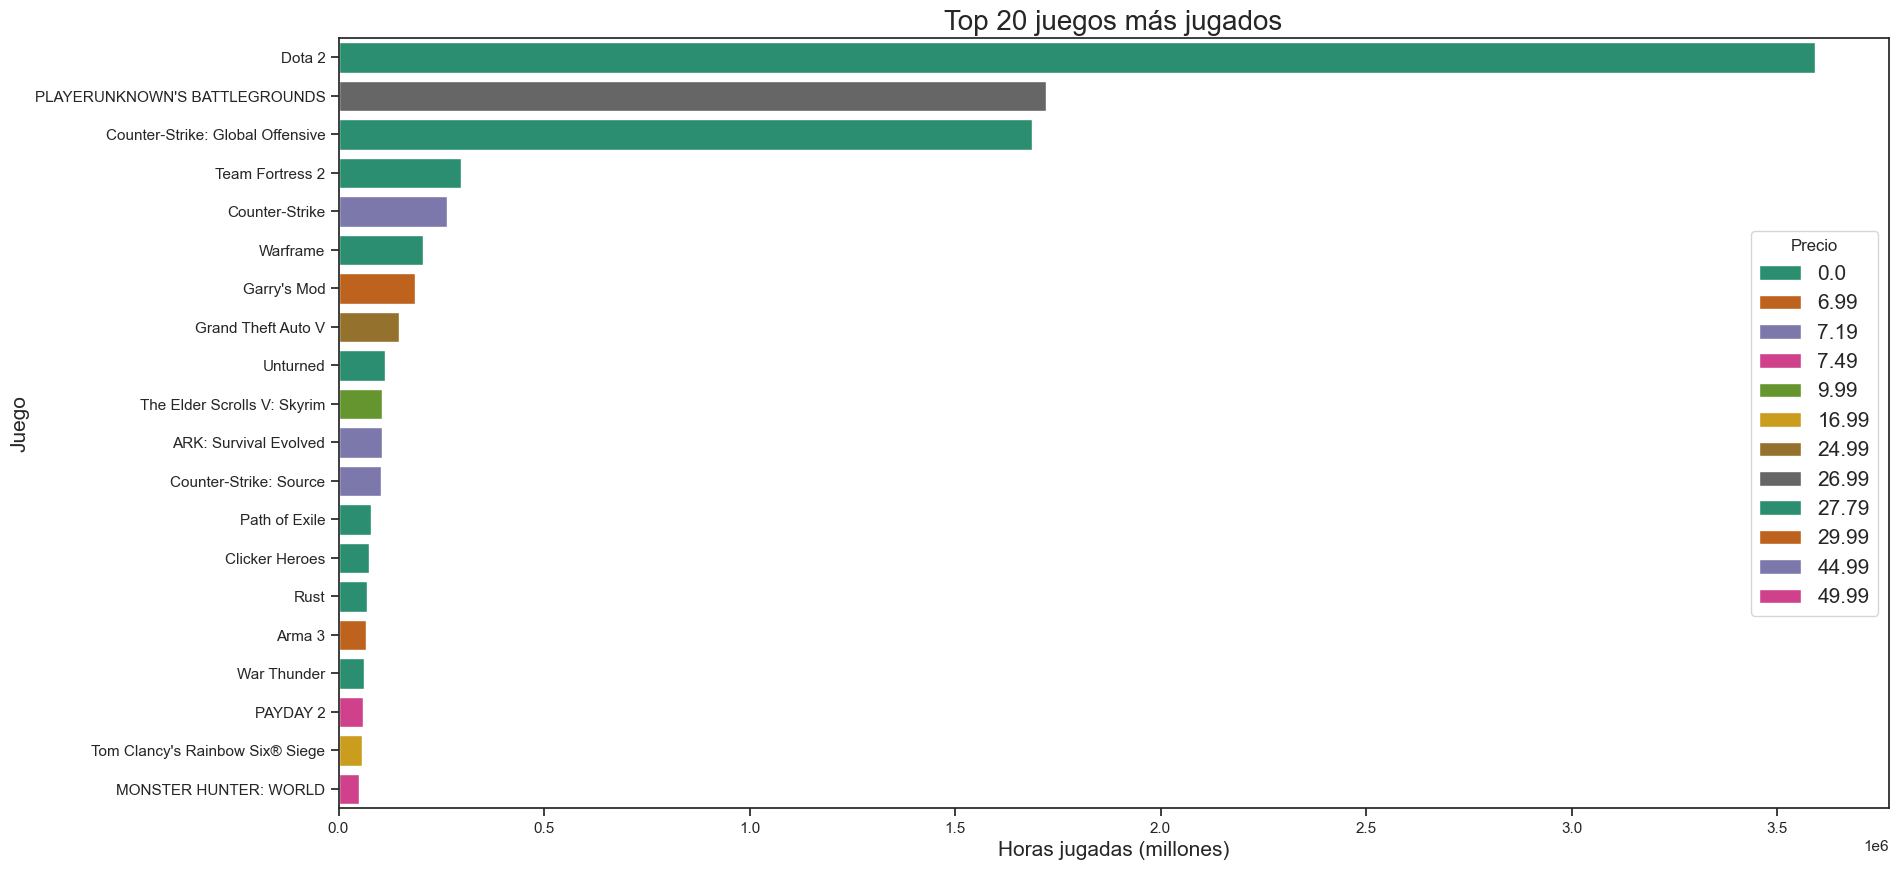

In [365]:
plt.figure(figsize=(20,10))
sns.barplot(y='name', x='playtime', data=most_played.head(20), palette='Dark2', hue='price',dodge=False)
plt.title('Top 20 juegos más jugados', fontsize=20)
plt.xlabel('Horas jugadas (millones)', fontsize=15)
plt.ylabel('Juego', fontsize=15)
plt.legend(fontsize=15, title='Precio')
plt.show()

## Cantidad de juegos por empresa

Dado que ya se ha empezado a adentrarse en el flujo de dinero generado por esta industria, es relevante ver cuántos juegos tienen publicados distintos distribuidores. Esto permite ver cuánta oferta se está dando por empresa, además de ver cuáles juegos aportan más dinero a las empresas más allá de su compra inicial, con expansiones de contenido o ediciones especiales, por ejemplo. Esto se comenta puesto que es posible que se encuentren empresas con muy pocos juegos, pero que a la vez ganen mucho (un gran ejemplo de esto es Minecraft, el juego más vendido de todos los tiempos, que por mucho tiempo fue el único juego de la compañía Mojang).

Teniendo esto en consideración, es posible ver que la empresa con más juegos en la plataforma es Big Fish Games, la cual cuenta con 212 juegos en Steam. Luego de ésta, le siguen otras distribuidoras más conocidas en el top 20, como Ubisoft, Square Enix y SEGA. ¿A qué se debe que esta compañía y otras menos conocidas tengan tantos juegos? El caso de la empresa con más juegos es bastante particular, ya que es una empresa especializada en juegos de casino o máquinas de azar, juegos que usualmente vienen en packs, requieren pocas especificaciones en el computador, suelen ser gratis o a bajo costo y ganan más al ser muy variados. Luego, se podría considerar este dato como un outlier, puesto que el género de juegos que aborda no resulta ser de los más jugados en la plataforma

In [366]:
games_publisher = steam.groupby(['publisher'])
games_publisher = games_publisher.size().reset_index(name='count')
games_publisher = games_publisher.sort_values(by=['count'], ascending=False)
games_publisher.head(10)


,publisher,count
1440,Big Fish Games,212
11243,Strategy First,136
12414,Ubisoft,111
11530,THQ Nordic,98
11058,Square Enix,97
10465,Sekai Project,96
2267,Choice of Games,94
2844,Dagestan Technology,88
99,1C Entertainment,88
10196,SEGA,78


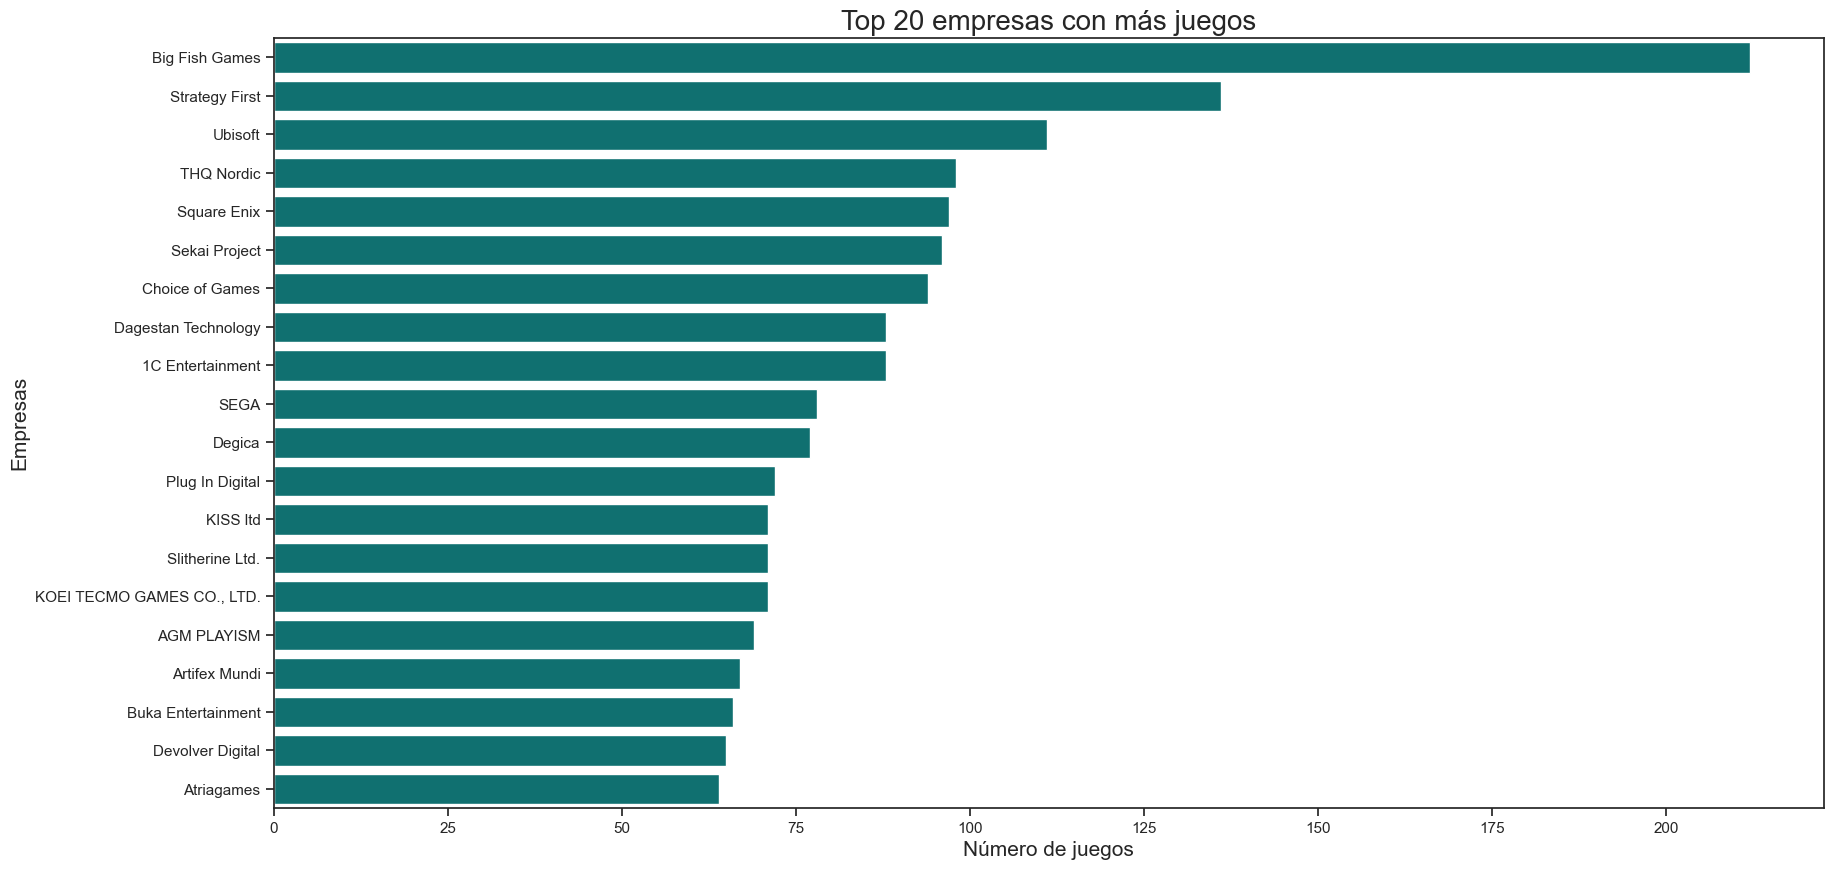

In [367]:
plt.figure(figsize=(20,10))
sns.barplot(y='publisher', x='count', data=games_publisher.head(20), color='teal', dodge=False)
plt.title('Top 20 empresas con más juegos', fontsize=20)
plt.xlabel('Número de juegos', fontsize=15)
plt.ylabel('Empresas', fontsize=15)
plt.show()

## Dinero vendido por juego según cada publicador

En el mercado de los videojuegos existen muchos publicadores famosos y conocidos por generar muchos ingresos. Sin embargo, no todos estos ingresos provienen de exclusivamente de la compra de su videojuego, pues en muchos casos obtienen ingresos por compras dentro del mismo juego o de mercancía relacionada con el juego. Sin embargo, se consideró que resultaría interesante ver que publicadores generaron más dinero con solo la compra de sus videojuegos, pues puede servir para esclarecer ideas sobre el ingreso de estos publicadores y sobre características de sus videojuegos, por ejemplo que no necesariamente se tiene que tener un juego a un precio elevado para poder obtener grandes cantidades de ingresos, o por ejemplo que puede ser mejor expandirse (Ubisoft Paris está bajo Ubisoft entertaiment, el cual es conocido de ser uno de las empresas que más grande de videojuegos) que no hacerlo (PUBG Corporation no genera más que Ubisoft a pesar de tener más ingreso por compra). El income calculado se obtuvo multiplicando el precio del juego por la cantidad promediada de compradores, eso para cada juego y luego se grupo por publisher, sumando todos los income de cada juego de cada publisher. Finalmente se ordenaron de menor a mayor y se graficaron los primeros 20.

In [368]:
revenue = steam.groupby(['publisher','owners','price'])
revenue = revenue.size().reset_index(name='count')
revenue['revenue'] = revenue['owners'] * revenue['price']/1000000
revenue = revenue.sort_values(by=['revenue'], ascending=False)
revenue.head(20)

,publisher,owners,price,count,revenue
13409,PUBG Corporation,75000000,26.99,1,2024.250
3153,"CAPCOM Co., Ltd.",7500000,49.99,1,374.925
15300,Rockstar Games,15000000,24.99,1,374.850
17419,Studio Wildcard,7500000,44.99,1,337.425
19830,Warner Bros Interactive Entertainment,7500000,44.99,1,337.425
6259,Facepunch Studios,7500000,27.79,1,208.425
3172,CD PROJEKT RED,7500000,24.99,1,187.425
282,2K;Aspyr (Mac);Aspyr (Linux),3500000,49.99,1,174.965
787,Activision (Excluding Japan and Asia);FromSoft...,3500000,49.90,1,174.650
13520,Paradox Interactive,7500000,22.99,1,172.425


c:\Users\nicol\Downloads\virtual\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 26041 (\N{CJK UNIFIED IDEOGRAPH-65B9}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\nicol\Downloads\virtual\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 22359 (\N{CJK UNIFIED IDEOGRAPH-5757}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\nicol\Downloads\virtual\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 28216 (\N{CJK UNIFIED IDEOGRAPH-6E38}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\nicol\Downloads\virtual\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 25103 (\N{CJK UNIFIED IDEOGRAPH-620F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


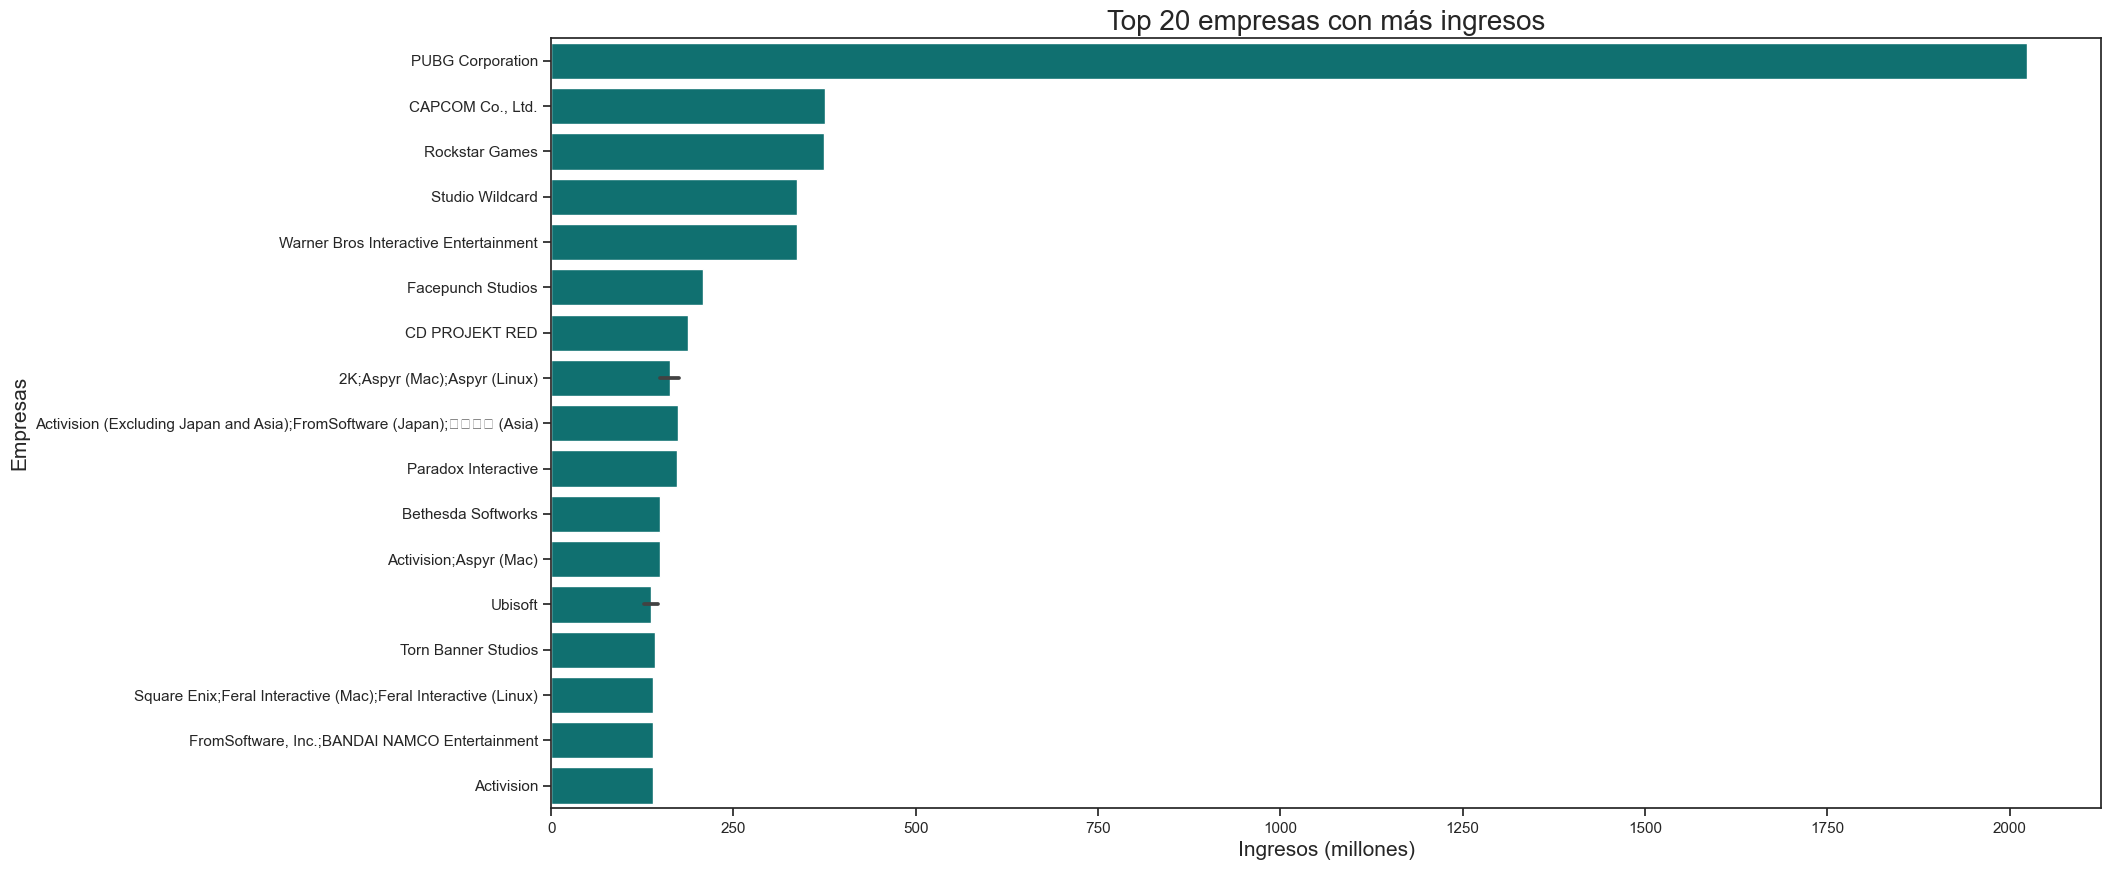

In [369]:
plt.figure(figsize=(20,10))
sns.barplot(y='publisher', x='revenue', data=revenue.head(20), color='teal', dodge=False)
plt.title('Top 20 empresas con más ingresos', fontsize=20)
plt.xlabel('Ingresos (millones)', fontsize=15)
plt.ylabel('Empresas', fontsize=15)
plt.show()

## Juegos gratis más populares

Los juegos free-to-play siempre han tenido una gran recepción y en muchos casos son relevantes a nivel competitivo global, es por eso por lo que puede resultar útil o interesante el ver que juegos gratuitos son los más valorados de acuerdo con el público consumidor, además de la cantidad de jugadores de aquellos juegos valorados muy positivamente. Además, se pueden ver las características que comparten los juegos mejor valorados como estudio de lo que le gusta al público consumidor (por ejemplo, que sea multijugador o que sea competitivo). El rating promedio se obtuvo como sumando la cantidad de rating positivos y negativos (estos quedan restando) y dividiéndolo por 2 (con el fin de aquellos que tengan muchos ratings positivos y que sean más que los negativos serán los que tienen un mejor rating en general), luego se ordenaron de acuerdo con el rating general de mayor a menor y se graficó el top 20.


In [370]:
popular_games = steam.groupby(['name','owners','positive_ratings','negative_ratings','price'])
popular_games = popular_games.size().reset_index(name='count')
popular_games = popular_games[popular_games['price'] == 0]
popular_games['average rating'] = (popular_games['positive_ratings'] + popular_games['negative_ratings'])/2
popular_games = popular_games.sort_values(by=['average rating'], ascending=False)
popular_games.head(10)


,name,owners,positive_ratings,negative_ratings,price,count,average rating
4813,Counter-Strike: Global Offensive,75000000,2644404,402313,0.0,1,1523358.5
6595,Dota 2,150000000,863507,142079,0.0,1,502793.0
21938,Team Fortress 2,35000000,515879,34036,0.0,1,274957.5
24595,Unturned,35000000,292574,31482,0.0,1,162028.0
25358,Warframe,35000000,226541,20268,0.0,1,123404.5
26224,Z1 Battle Royale,15000000,111434,91664,0.0,1,101549.0
16094,Paladins®,15000000,169580,32407,0.0,1,100993.5
12707,Life is Strange - Episode 1,7500000,118634,4496,0.0,1,61565.0
6478,Doki Doki Literature Club!,3500000,108556,3588,0.0,1,56072.0
18286,Robocraft,15000000,80360,30987,0.0,1,55673.5


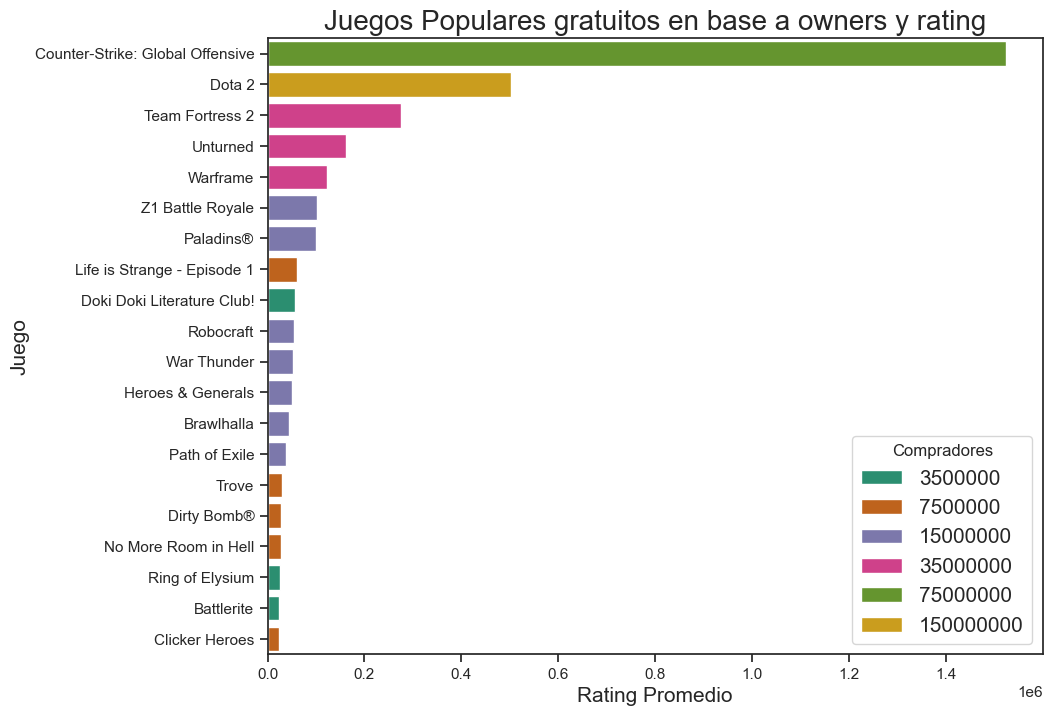

In [371]:
plt.figure(figsize=(10,8))
sns.barplot(y='name', x='average rating', data=popular_games.head(20), palette='Dark2', hue='owners',dodge=False)
plt.title('Juegos Populares gratuitos en base a owners y rating', fontsize=20)
plt.xlabel('Rating Promedio', fontsize=15)
plt.ylabel('Juego', fontsize=15)
plt.legend(fontsize=15, title='Compradores')
plt.show()

## Juegos Lanzados Por Año

Viendo todo lo que se ha descrito anteriormente, es relevante ver cómo ha sido el crecimiento de juegos disponibles en la empresa a lo largo de los años. Como se mencionó al inicio, la industria de los juegos es una de las más importantes ahora mismo y esto implica que cada vez habrá más demanda por contenido similar. Luego, si se tiene cómo ha sido el crecimiento de estos, se podría generar un modelo capaz de predecir o estimar la cantidad de videojuegos disponibles que habrán en algunos años más.

En consecuencia, se puede ver que en la última década ha habido un crecimiento exponencial de la cantidad de juegos ofrecidos en la plataforma. Se ve que el crecimiento fue paulatino y estable para los primeros años en que se iban publicando juegos, pero ya a partir del 2013 en adelante cada año crecía cada vez más este número. Cabe mencionar que los datos tienen juegos hasta mayo del 2019, por lo que esta barra debería estar mucho más alta que la de 2018 al final de ese periodo de tiempo. ¿Por qué ocurre este boom en la cantidad de juegos ofrecidos? El fenómeno puede explicarse por varias razones, siendo las principales el que en la última década se ha facilitado el desarrollo y distribución independiente de juegos, por lo que es posible que una sola persona haga un juego; además de que cada vez más persona comienzan a disfrutar de los videojuegos, siendo que la cultura “gamer” ha ido tomando espacio en la cultura actual. Junto con lo anterior, los avances tecnológicos han facilitado el aumento de especificaciones en los computadores con tal de que casi cualquier persona pueda tener los requerimientos mínimos para poder jugar, lo que aumenta su demanda y así la oferta para satisfacerla. Con todo esto, se esperaría que la cantidad de juegos en Steam siga aumentando en una tasa similar, sin embargo, tal como ocurrió al inicio del gráfico mostrado, se espera que en algún momento la cantidad ofrecida se estanque por un tiempo, tanto por factores externos globales como por factores respecto a la producción de hardware y software suficientemente novedoso como para mantener este crecimiento exponencial.

In [372]:
anio=pd.DataFrame(steam['release_date'].str.split('-',expand=True))
anio.columns=['anio','mes','dia']
juegos_anio=steam.join(anio)
juegos_anio=juegos_anio.groupby(['anio'])
juegos_anio=juegos_anio.size().reset_index(name='count')
juegos_anio=juegos_anio.sort_values(by=['anio'], ascending=False)
juegos_anio.head(10)



,anio,count
22,2019,2213
21,2018,8160
20,2017,6357
19,2016,4361
18,2015,2597
17,2014,1555
16,2013,418
15,2012,320
14,2011,239
13,2010,238


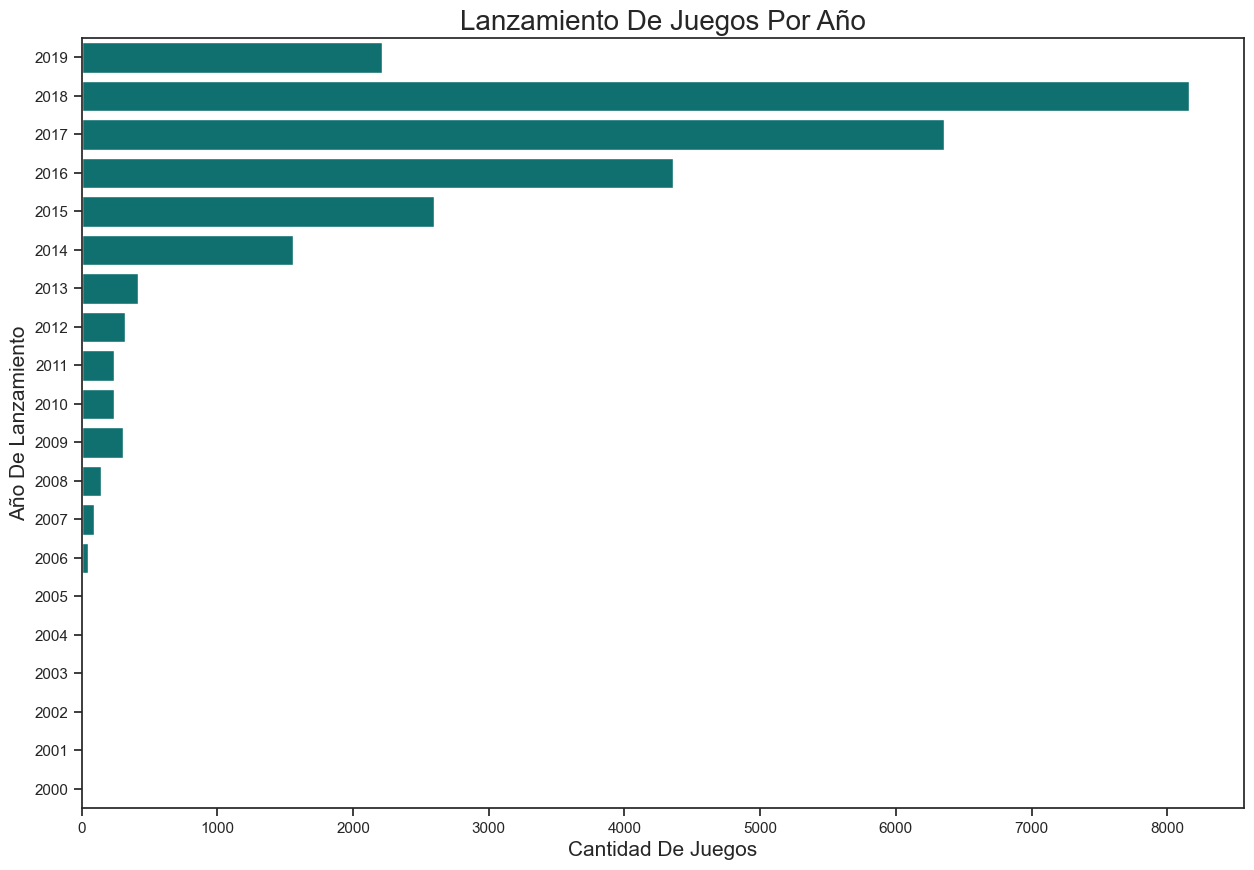

In [373]:
plt.figure(figsize=(15,10))
sns.barplot(y='anio', x='count', data=juegos_anio.head(20), color='teal', dodge=False)
plt.title('Lanzamiento De Juegos Por Año', fontsize=20)
plt.xlabel('Cantidad De Juegos', fontsize=15)
plt.ylabel('Año De Lanzamiento', fontsize=15)
plt.show()

In [374]:
docs = steam

for i in range(len(X_g['platforms'])):
    X_g['platforms'][i] = X_g['platforms'][i].lower().split(';')
    X_g['platforms'][i].sort()
    X_g['platforms'][i] = '; '.join(X_g['platforms'][i])

uniques = docs["genres"].unique().tolist()

for i in range(len(X_g['platforms'])):
    X_g['platforms'][i] = uniques.index(X_g['platforms'][i])


C:\Users\nicol\AppData\Local\Temp\ipykernel_26820\3118378800.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  docs['genres'][i] = docs['genres'][i].lower().split(';')
C:\Users\nicol\AppData\Local\Temp\ipykernel_26820\3118378800.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  docs['genres'][i] = '; '.join(docs['genres'][i])
C:\Users\nicol\AppData\Local\Temp\ipykernel_26820\3118378800.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-

In [36]:
X_g = steam.copy()

# Eliminar columnas innecesarias
X_g = X_g.drop(['appid', 'name', 'release_date', 'developer', 'publisher'], axis=1)

# Codificando platforms
for i in range(len(X_g['platforms'])):
    X_g['platforms'][i] = X_g['platforms'][i].lower().split(';')
    X_g['platforms'][i].sort()
    X_g['platforms'][i] = '; '.join(X_g['platforms'][i])

uniques_p = X_g['platforms'].unique().tolist()

for i in range(len(X_g['platforms'])):
    X_g['platforms'][i] = uniques_p.index(X_g['platforms'][i])


# Codificando categories
for i in range(len(X_g['categories'])):
    X_g['categories'][i] = X_g['categories'][i].lower().split(';')
    X_g['categories'][i].sort()
    X_g['categories'][i] = '; '.join(X_g['categories'][i])

uniques_c = X_g['categories'].unique().tolist()

for i in range(len(X_g['categories'])):
    X_g['categories'][i] = uniques_c.index(X_g['categories'][i])


# Codificando steamspy_tags
for i in range(len(X_g['steamspy_tags'])):
    X_g['steamspy_tags'][i] = X_g['steamspy_tags'][i].lower().split(';')
    X_g['steamspy_tags'][i].sort()
    X_g['steamspy_tags'][i] = '; '.join(X_g['steamspy_tags'][i])

uniques_s = X_g['steamspy_tags'].unique().tolist()

for i in range(len(X_g['steamspy_tags'])):
    X_g['steamspy_tags'][i] = uniques_s.index(X_g['steamspy_tags'][i])

C:\Users\sanfe\AppData\Local\Temp\ipykernel_15836\1007333165.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_g['platforms'][i] = X_g['platforms'][i].lower().split(';')
C:\Users\sanfe\AppData\Local\Temp\ipykernel_15836\1007333165.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_g['platforms'][i] = '; '.join(X_g['platforms'][i])
C:\Users\sanfe\AppData\Local\Temp\ipykernel_15836\1007333165.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

In [37]:
# Definiendo los géneros como indie (1) o no indie (0)
for i in range(len(X_g['genres'])):
    l = X_g['genres'][i].lower().split(';')
    c = l.count('indie')
    if c > 0:
        X_g['genres'][i] = 1
    else:
        X_g['genres'][i] = 0

C:\Users\sanfe\AppData\Local\Temp\ipykernel_15836\2720120216.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_g['genres'][i] = 0
C:\Users\sanfe\AppData\Local\Temp\ipykernel_15836\2720120216.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_g['genres'][i] = 1


In [38]:
# Datos y clase
y_g = X_g['genres'].astype('int64')
X_g1 = X_g.drop('genres', axis=1)

In [8]:
def run_classifier(clf, X, y, num_tests=100):
    metrics = {'f1_micro': [], 'precision_micro': [], 'recall_micro': []}
    
    for _ in range(num_tests):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30)
        clf1 = clf
        clf1.fit(X_train,y_train)
        predictions = clf1.predict(X_test)
         
        metrics['y_pred'] = predictions
        metrics['f1_micro'].append(f1_score(y_test, predictions, average='micro')) 
        metrics['recall_micro'].append(recall_score(y_test, predictions, average='micro'))
        metrics['precision_micro'].append(precision_score(y_test, predictions, average='micro'))

    return metrics

In [39]:
c0 = ("Base Dummy", DummyClassifier(strategy='stratified'))
c1 = ("Decision Tree", DecisionTreeClassifier(max_depth=5))
c2 = ("Gaussian Naive Bayes", GaussianNB())
c3 = ("KNN", KNeighborsClassifier(n_neighbors=10))


classifiers = [c0, c1, c2, c3]

results = {}
for name, clf in classifiers:
    metrics = run_classifier(clf, X_g1, y_g)
    results[name] = metrics
    print("----------------")
    print("Resultados para clasificador: ", name) 
    print("Precision promedio:", np.array(metrics['precision_micro']).mean())
    print("Recall promedio:", np.array(metrics['recall_micro']).mean())
    print("F1-score promedio:", np.array(metrics['f1_micro']).mean())
    print("----------------\n\n")  

----------------
Resultados para clasificador:  Base Dummy
Precision promedio: 0.5942348885879601
Recall promedio: 0.5942348885879601
F1-score promedio: 0.5942348885879601
----------------


----------------
Resultados para clasificador:  Decision Tree
Precision promedio: 0.7669506340022159
Recall promedio: 0.7669506340022159
F1-score promedio: 0.7669506340022159
----------------


----------------
Resultados para clasificador:  Gaussian Naive Bayes
Precision promedio: 0.7212175304690386
Recall promedio: 0.7212175304690386
F1-score promedio: 0.7212175304690386
----------------


----------------
Resultados para clasificador:  KNN
Precision promedio: 0.7700960236365876
Recall promedio: 0.7700960236365876
F1-score promedio: 0.7700960236365876
----------------




In [40]:
# Encontrando los mejores hiperparámetros para el árbol de decisión

X_train, X_test, y_train, y_test = train_test_split(X_g1, y_g, test_size=.30, random_state=37)



#Configure tuned_parameters
tuned_parameters = {'max_depth': [5,7,9,10,11,15,20],
                    'criterion': ['gini','entropy']}

#set scoring metric
score = 'f1_micro' 

#Construir el clf con GridSearch
clf = GridSearchCV(DecisionTreeClassifier(), 
                   param_grid=tuned_parameters, 
                   cv=5,
                   scoring=score)

#Entrenar clf
clf.fit(X_train, y_train)


##### FIN COMPLETE ACÁ
print("Mejor combinación de parámetros:")
print(clf.best_params_)
 
y_true, y_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, y_pred))

Mejor combinación de parámetros:
{'criterion': 'entropy', 'max_depth': 11}
              precision    recall  f1-score   support

           0       0.72      0.57      0.64      2264
           1       0.85      0.92      0.88      5859

    accuracy                           0.82      8123
   macro avg       0.79      0.74      0.76      8123
weighted avg       0.81      0.82      0.81      8123



In [41]:
# Encontrando los mejores hiperparámetros para KNN

tuned_parameters = {'n_neighbors': [10,15,20,25,30,35,40], 
                    'weights': ['distance','uniform']}

score = 'precision_weighted'

clf = GridSearchCV(KNeighborsClassifier(), 
                   param_grid=tuned_parameters, 
                   cv=5,
                   scoring=score)

clf.fit(X_train, y_train)

print("Mejor combinación de parámetros:")
print(clf.best_params_)
 
y_true, y_pred = y_test, clf.predict(X_test)

print(classification_report(y_true, y_pred))

Mejor combinación de parámetros:
{'n_neighbors': 10, 'weights': 'distance'}
              precision    recall  f1-score   support

           0       0.66      0.49      0.57      2264
           1       0.82      0.90      0.86      5859

    accuracy                           0.79      8123
   macro avg       0.74      0.70      0.71      8123
weighted avg       0.78      0.79      0.78      8123



In [62]:
print(data_train['genres'].value_counts())

1    13594
0     5358
Name: genres, dtype: int64


In [80]:
# Over y Under sampling

X_train, X_test, y_train, y_test = train_test_split(X_g, X_g['genres'], test_size=.30, random_state=37, stratify=X_g['genres'])

# Para que no sean objetos
y_test = y_test.astype('int64')
y_train = y_train.astype('int64')

label='genres'
data_test = X_test
data_test[label] = y_test
data_test = data_test.reset_index(drop=True)
data_train = X_train
data_train[label] = y_train
data_train = data_train.reset_index(drop=True)

# Oversampling
idx = np.random.choice(data_train[data_train[label] == 0].index, size=8236)
data_oversampled = pd.concat([data_train, data_train.iloc[idx]])

# Subsampling
idx = np.random.choice(data_train.loc[data_train[label] == 1].index, size=8236, replace=False)
data_subsampled = data_train.drop(data_train.iloc[idx].index)

In [81]:
# Preparando los data frames para ser compatibles con sklearn

# datos test (mismo para todos los conjuntos de entrenamiento)
X_test = data_test.drop('genres', axis=1)
y_test = data_test['genres']

# datos entrenamiento "originales"
X_orig = data_train.drop('genres', axis=1)
y_orig = data_train['genres']

# datos entrenamiento "oversampleados" 
X_over = data_oversampled.drop('genres', axis=1)
y_over = data_oversampled['genres']

# datos entrenamiento "subsampleados"
X_subs = data_subsampled.drop('genres', axis=1)
y_subs = data_subsampled['genres']

In [82]:
print("ORIGINAL::::::::::")
clf_orig = DecisionTreeClassifier(max_depth=11, criterion='entropy')
clf_orig.fit(X_orig, y_orig)
pred_orig = clf_orig.predict(X_test)
print(classification_report(y_test, pred_orig))

print("OVERSAMPLING::::::::::")
clf_over = DecisionTreeClassifier(max_depth=11, criterion='entropy')
clf_over.fit(X_over, y_over)
pred_over = clf_over.predict(X_test)
print(classification_report(y_test, pred_over))

print("SUBSAMPLING::::::::::")
clf_subs = DecisionTreeClassifier(max_depth=11, criterion='entropy')
clf_subs.fit(X_subs, y_subs)
pred_subs = clf_subs.predict(X_test)
print(classification_report(y_test, pred_subs))

ORIGINAL::::::::::
              precision    recall  f1-score   support

           0       0.70      0.58      0.63      2296
           1       0.84      0.90      0.87      5827

    accuracy                           0.81      8123
   macro avg       0.77      0.74      0.75      8123
weighted avg       0.80      0.81      0.80      8123

OVERSAMPLING::::::::::
              precision    recall  f1-score   support

           0       0.57      0.75      0.65      2296
           1       0.89      0.78      0.83      5827

    accuracy                           0.77      8123
   macro avg       0.73      0.76      0.74      8123
weighted avg       0.80      0.77      0.78      8123

SUBSAMPLING::::::::::
              precision    recall  f1-score   support

           0       0.57      0.80      0.67      2296
           1       0.91      0.76      0.83      5827

    accuracy                           0.77      8123
   macro avg       0.74      0.78      0.75      8123
weighted a